# Параллельные вычисления (1)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html

## Задачи для совместного разбора

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя пул процессов.

In [ ]:
import multiprocessing

files = [f"data/{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [ ]:
%%file f.py
def count_a(file_name):
    with open(file_name, "r") as fp:
        text = fp.read()
    a = text.count("a")
    print(f"{file_name} => {a}")
    return a

In [ ]:
from f import count_a

In [ ]:
%%time
a = []
for file in files:
    a.append(count_a(file))
sum(a) 

In [ ]:
map

In [ ]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    r = pool.map(count_a, files) 
sum(r)

In [ ]:
r

2. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя процессы и очереди.

In [ ]:
%%file f_queue.py
def count_a_queue(file_name, queue):
    with open(file_name, "r") as fp:
        text = fp.read()
    a = text.count("a")
    print(f"{file_name} => {a}")
    queue.put(a)
    # ...

In [ ]:
from f_queue import count_a_queue

In [ ]:
%%time
# 0. Хранилище
queue = multiprocessing.Queue()
# 1. создать процессы
processes = []
for file in files:
    p = multiprocessing.Process(target=count_a_queue, args=(file, queue))
    p.start()
    processes.append(p)

In [ ]:
# мы уверены, что все процессы завершились
# 3. забираем значения

In [ ]:
res = []
while len(res) < len(files):
    if not queue.empty():
        r = queue.get()
        res.append(r)
sum(res)

In [ ]:
# 2(4). ждем окончания работы процессов
for p in processes:
    p.join()

In [ ]:
sum(res)

## Лабораторная работа 5

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp

<p class="task" id="1"></p>

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок). 

При создании файлов выводите на экран сообщения следующего вида:
`file: <название файла> #rows: <кол-во строк в этом файле>`

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [2]:
n_files = 10

In [3]:
chunks = pd.read_csv(f'tag_nsteps.csv', chunksize=71_000_000//n_files)
for i, chunk in enumerate(chunks):
    chunk.to_csv(f'tag_nsteps_{i}.csv', index=False)
    a = len(pd.read_csv(f'tag_nsteps_{i}.csv'))
    print(f'file: tag_nsteps_{i}.csv #rows: {a}')

file: tag_nsteps_0.csv #rows: 7100000
file: tag_nsteps_1.csv #rows: 7100000
file: tag_nsteps_2.csv #rows: 7100000
file: tag_nsteps_3.csv #rows: 7100000
file: tag_nsteps_4.csv #rows: 7100000
file: tag_nsteps_5.csv #rows: 7100000
file: tag_nsteps_6.csv #rows: 7100000
file: tag_nsteps_7.csv #rows: 7100000
file: tag_nsteps_8.csv #rows: 7100000
file: tag_nsteps_9.csv #rows: 6795585


<p class="task" id="2"></p>

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [4]:
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    df2 = df.groupby("tags")["n_steps"]
    df3 = df2.agg(['sum', 'count'])
    return df3.to_dict('index')

In [5]:
res2 = [get_tag_sum_count_from_file(f"tag_nsteps_{i}.csv") for i in range(n_files)]

In [6]:
for dict_ in res2:
    print(dict_["30-minutes-or-less"])

{'sum': 279827, 'count': 36539}
{'sum': 277417, 'count': 36499}
{'sum': 284850, 'count': 37268}
{'sum': 278416, 'count': 36680}
{'sum': 279948, 'count': 36588}
{'sum': 276459, 'count': 36448}
{'sum': 279818, 'count': 36791}
{'sum': 279457, 'count': 36782}
{'sum': 278586, 'count': 36755}
{'sum': 268427, 'count': 35432}


<p class="task" id="3"></p>

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [7]:
def agg_results(tag_sum_count_list: list) -> dict:
    main_df = pd.DataFrame(columns=["index", "sum", "count"])
    for dict_ in tag_sum_count_list:
        temp = pd.DataFrame.from_dict(dict_, orient="index").reset_index()
        main_df = pd.concat([temp, main_df])
    res = main_df.groupby("index").sum().to_dict("index")
    return res

In [8]:
res3 = agg_results(res2)

In [9]:
res3["30-minutes-or-less"]

{'sum': 2783205, 'count': 365782}

<p class="task" id="4"></p>

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре. Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла, можно пренебречь.

In [10]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    for tag, sum_count in tag_sum_count.items():
        tag_sum_count[tag] = sum_count["sum"] / sum_count["count"]
    return tag_sum_count
    pass

In [11]:
%%time
res4 = get_tag_mean_n_steps(agg_results([get_tag_sum_count_from_file(f"tag_nsteps_{i}.csv") for i in range(n_files)]))
res4["30-minutes-or-less"]

Wall time: 20.1 s


7.608917333275011

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [12]:
%%file functions.py
import pandas as pd

def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    df2 = df.groupby("tags")["n_steps"]
    df3 = df2.agg(sum = 'sum', count = 'count')
    return df3.to_dict('index')

Overwriting functions.py


In [13]:
import functions

In [14]:
%%time
pool = mp.Pool(processes=n_files)
results = list(pool.map(functions.get_tag_sum_count_from_file, [f'tag_nsteps_{i}.csv' for i in range(n_files)]))
res5 = get_tag_mean_n_steps(agg_results(results))
res5["30-minutes-or-less"]

Wall time: 3.75 s


7.608917333275011

<p class="task" id="6"></p>

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [15]:
%%file functions2.py
import pandas as pd

def get_tag_sum_count_from_file(file: str, output) -> dict:
    df = pd.read_csv(file)
    df2 = df.groupby("tags")["n_steps"]
    df3 = df2.agg(sum = 'sum', count = 'count')
    output.put(df3.to_dict('index'))

Overwriting functions2.py


In [16]:
import functions2

In [17]:
%%time
processes = []
output = mp.Queue()
for i in range(n_files):
    mp.Process(target=functions2.get_tag_sum_count_from_file, args=(f"tag_nsteps_{i}.csv", output)).start()
    
results = []
for _ in range(n_files):
    results.append(output.get())

res6 = get_tag_mean_n_steps(agg_results(results))
res6["30-minutes-or-less"]

Wall time: 3.98 s


7.608917333275011

<p class="task" id="7"></p>

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$ (воспользуйтесь функцией `multiprocessing.cpu_count`). Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

In [18]:
mp.cpu_count()

16

In [19]:
n_files = mp.cpu_count()//2
chunks = pd.read_csv(f'tag_nsteps.csv', chunksize=71_000_000//n_files)
for i, chunk in enumerate(chunks):
    chunk.to_csv(f'8tag_nsteps_{i}.csv', index=False)

In [20]:
%%time
pool = mp.Pool(processes = n_files)
results = list(pool.map(functions.get_tag_sum_count_from_file, [f'8tag_nsteps_{i}.csv' for i in range(n_files)]))
res5 = get_tag_mean_n_steps(agg_results(results))

Wall time: 4.46 s


In [21]:
n_files = mp.cpu_count()
chunks = pd.read_csv(f'tag_nsteps.csv', chunksize=71_000_000//n_files)
for i, chunk in enumerate(chunks):
    chunk.to_csv(f'16tag_nsteps_{i}.csv', index=False)

In [22]:
%%time
pool = mp.Pool(processes = n_files)
results = list(pool.map(functions.get_tag_sum_count_from_file, [f'16tag_nsteps_{i}.csv' for i in range(n_files)]))
res5 = get_tag_mean_n_steps(agg_results(results))

Wall time: 3.76 s


In [23]:
n_files = mp.cpu_count()*2
chunks = pd.read_csv(f'tag_nsteps.csv', chunksize=71_000_000//n_files)
for i, chunk in enumerate(chunks):
    chunk.to_csv(f'32tag_nsteps_{i}.csv', index=False)

In [24]:
%%time
pool = mp.Pool(processes = n_files)
results = list(pool.map(functions.get_tag_sum_count_from_file, [f'32tag_nsteps_{i}.csv' for i in range(n_files)]))
res5 = get_tag_mean_n_steps(agg_results(results))

Wall time: 5.32 s


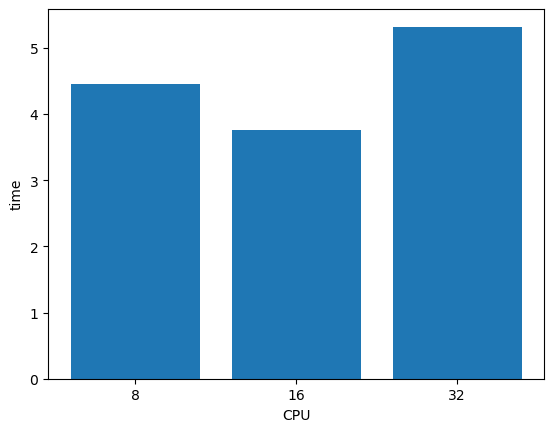

In [25]:
import matplotlib.pyplot as plt

CPU = ['8', '16', '32']
time = [4.46, 3.76, 5.32]

plt.bar(CPU, time)

plt.xlabel('CPU')
plt.ylabel('time')

plt.show()

Наиболее эффективно использовать кол-во процессов, равное кол-ву потоков процессора, т.к. задействуются все потоки. Если же использовать процессов больше, чем потоков, то производительность снижается, т.к. все процессы делят между собой общие ресурсы, а если увеличивать число процессов, претендующих на доступ к одним и тем же ресурсам, то это может приводить к задержкам.